<a href="https://colab.research.google.com/github/horasan/ml/blob/main/R_LER_TREASURY_FIXED_INCOME_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
from IPython.display import display, HTML
import math
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None) # all the columns will be shown
pd.set_option('display.max_rows', 99) # 99 of the possible rows will be shown

In [107]:
drive.mount('/content/drive')
DRIVE_DATASET_PATH = "/content/drive/My Drive/Colab Notebooks/0_R_LER/TREASURY/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#0) Functions

## calculate_compounded_interest

In [108]:
# TODO: Document needed,
# TODO: There is no exception handling
def calculate_compounded_interest(X, m, r, t):
  P_t = ((1 + r / m)**(t*m))*X
  return P_t

## get_equivalent_rate

In [109]:
# TODO: Document needed: P_t is the future value.
# TODO: There is no exception handling
def get_equivalent_rate(P_t, X, m, t):
  r = ((P_t / X)**(1/(t*m)) - 1)*m
  return r

## calculate_present_value

In [110]:
# TODO: Document needed,
# TODO: There is no exception handling
# total_return_amount: amount to be paind in the future, r: prevailing interest rate, m: frequency per year, t: duration (unit is year)
def calculate_present_value(total_return_amount, r, m, t):
  PV = total_return_amount / ((1 + r/m) ** (m*t))
  return PV

## print_bond_present_value_description

In [111]:
# TODO: Document needed,
# TODO: There is no exception handling

def print_bond_present_value_description(bond_pre_future_data):
  total_present_value = 0.0;
  for index, row in bond_pre_future_data.iterrows(): # for each row in the DataFrame
    total_present_value = total_present_value + row["present_value"]
    print("${:.2f}".format(row["coupon_value"]), " will be paid ", row["time"], " year(s) later. Present value of ", "${:.2f}".format(row["coupon_value"]), " is ", "${:.2f}".format(row["present_value"]))
  print("Present value of the bond is " +  "${:.2f}".format(total_present_value))



## get_formatted_amout

In [112]:
def get_formatted_amout(amount):
    return "${:.2f}".format(amount)

#1) Compounded Interest

**Example**: Calculate the future value of 5 years of a $15.000 investment at the risk free rate if the semiannually compounded rate for this term is 6%.
Do the same using a montly compounded rate of 5.5%.

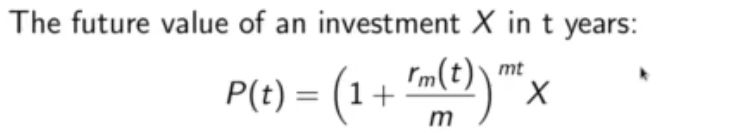



*   P(t) = Future Value
*   m = frequency (m times per year)
*   t = unit is year
*   X = initial investment






In [113]:
X = 15000
m = 2 # semiannually compounded
r = 0.06
t = 5 # years

P_t = (1 + r / m)**(t*m)*X
P_t # future value of X in the given parameters
print("P(t) for %", X, "m=", m, "r=", r , "t=", t,  "years: ", P_t)


P(t) for % 15000 m= 2 r= 0.06 t= 5 years:  20158.74569016183


In [114]:
X = 15000
m = 12 # montly compounded
r = 0.055
t = 5 # years

P_t = (1 + r / m)**(t*m)*X
P_t # future value of X in the given parameters
print("P(t) for %", X, "m=", m, "r=", r , "t=", t,  "years: ", P_t)

P(t) for % 15000 m= 12 r= 0.055 t= 5 years:  19735.55658804324


In [115]:
print(calculate_compounded_interest(15000, 2, 0.06, 5))
print(calculate_compounded_interest(15000, 12, 0.055, 5))

20158.74569016183
19735.55658804324


#2) Interest rate conversions

**Example**: If the annually compounded interest rate is 5%, what is the corresponding semiannualy compounded interest rate?

In [116]:
X = 1 # assume initial investment is $1
m = 1 # annually
r = 0.05
t = 1 # assume loan duration is 1 year

X_2 = 1 # same amount
m_2 = 2 # semi annually
r_2 = 0 # unknown
t_2 = 1 # same duration

P_t_1 = calculate_compounded_interest(X, m, r, t)
print(P_t_1)
print(get_equivalent_rate(P_t_1, 1, 2, 1))


1.05
0.04939015319191986


#3) Continuous Compounding: TODO


#4) Bonds and Discounted Cash Flow Analysis

## **Example**:

Calculate the price of a bond with a $1000 face value which pays annual coupon(interest) of 5%, and which matures in 4 years. Assume the prevailing interest rate (annually compounded) is 6% for all loan terms (flat term structure).

## Given bond information

In [117]:
coupon_rate = 5/100
t = 4
r = 6/100
face_value = 1000
m = 1 # annually payment

c1 = face_value * coupon_rate # 1 year later
t1 =1

c2 = face_value * coupon_rate # 2 years later
t2 =2

c3 = face_value * coupon_rate # 3 years later
t3 =3

c4 = (face_value * coupon_rate) + face_value # 4 years later
t4 =4



## Calculate present values for each payment

In [118]:
# initialize bond information.
bond_info = {
    'coupon_value': [c1, c2, c3, c4],
    'time': [t1, t2, t3, t4]
    }

# Create DataFrame
bond_data = pd.DataFrame(bond_info)

# add 'present value' data to dataframe
bond_data["present_value"] = bond_data.apply(lambda row: calculate_present_value(row["coupon_value"], r, m, row["time"]), axis=1)

bond_data

,coupon_value,time,present_value
0,50.0,1,47.169811
1,50.0,2,44.499822
2,50.0,3,41.980964
3,1050.0,4,831.698346


## Barplot of the payments

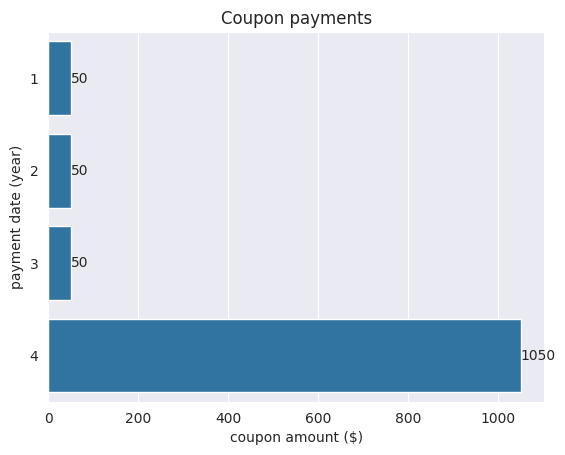

In [119]:
# Plot barplot with seaborn for the coupon payments
ax = sns.barplot(data = bond_data, y = "time", x = "coupon_value", orient='h')
ax.bar_label(ax.containers[0]) # TODO: amount' larin onune $ nasil ekleniyor?
ax.set(
    title='Coupon payments',
    xlabel='coupon amount ($)',
    ylabel='payment date (year)'
    )
#ax.set(xlabel='common xlabel', ylabel='common ylabel')
plt.show()

#type(ax.containers[0])
## "${:.2f}".format(a)

In [120]:
bond_data

,coupon_value,time,present_value
0,50.0,1,47.169811
1,50.0,2,44.499822
2,50.0,3,41.980964
3,1050.0,4,831.698346


## Print the bond life cycle

In [121]:
print_bond_present_value_description(bond_data)

$50.00  will be paid  1.0  year(s) later. Present value of  $50.00  is  $47.17
$50.00  will be paid  2.0  year(s) later. Present value of  $50.00  is  $44.50
$50.00  will be paid  3.0  year(s) later. Present value of  $50.00  is  $41.98
$1050.00  will be paid  4.0  year(s) later. Present value of  $1050.00  is  $831.70
Present value of the bond is $965.35


NOTE: Present value of the bond is $965.35

This amount of $965.35 is called DIRTY PRICE since this calculation does not take into account the accured interest!

## Scatter Plot of the present values of the payments

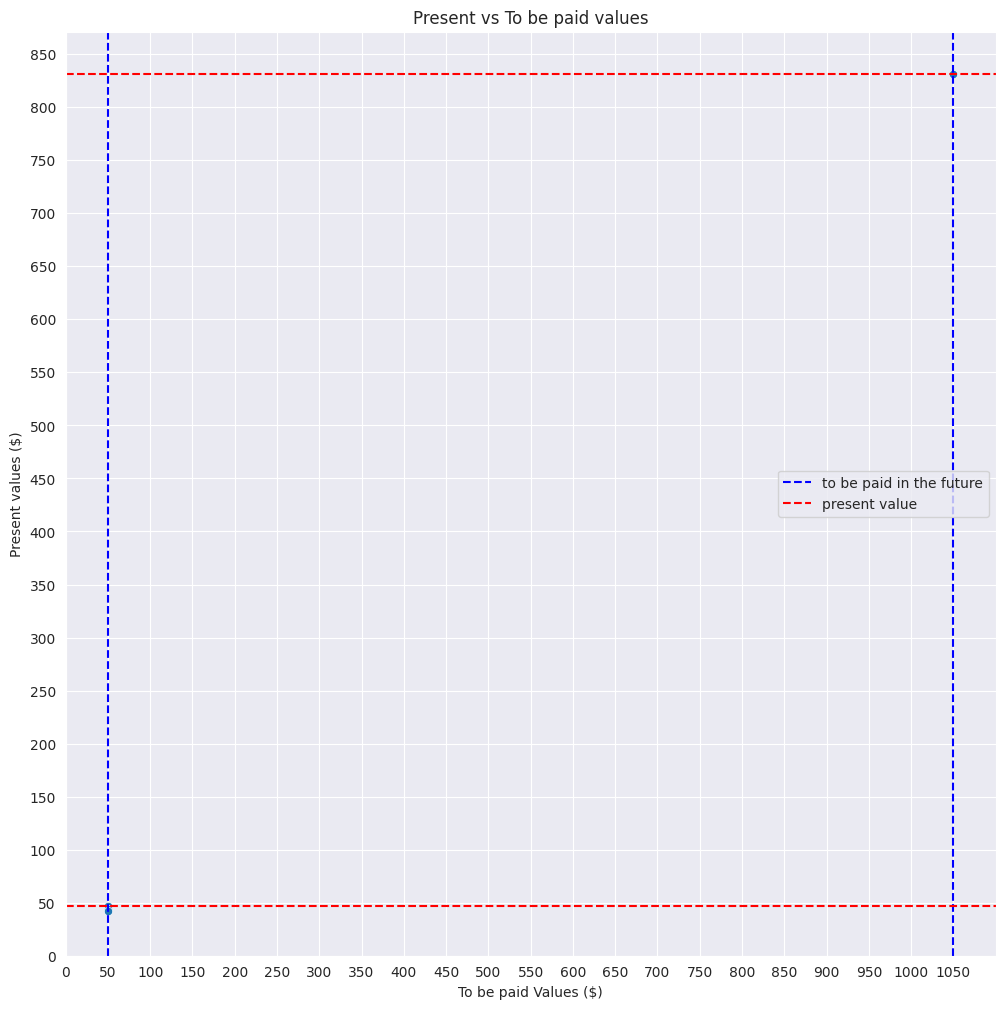

In [122]:
plt.figure(figsize=(12, 12))

# present value vs future value plot
ax = sns.scatterplot(data=bond_data, x="coupon_value",
                    y="present_value")
ax.set_xlim(0, 1100)
ax.set_xticks(np.arange(start=0, stop=1100, step=50))
ax.set_yticks(np.arange(start=0, stop=900, step=50))



ax.axvline(bond_data.iloc[0]["coupon_value"], color="blue", linestyle="--", label="to be paid in the future")
ax.axvline(bond_data.iloc[3]["coupon_value"], color="blue", linestyle="--")

ax.axhline(bond_data.iloc[0]["present_value"], color="red", linestyle="--", label="present value")
ax.axhline(bond_data.iloc[3]["present_value"], color="red", linestyle="--")

ax.set(
    title='Present vs To be paid values',
    xlabel='To be paid Values ($)',
    ylabel='Present values ($)'
    )
ax.legend(loc="center right")

plt.show()

# TODO: 50 ve 1050' leri x ekseninde nasil isaretleyecegim?
# TODO: PV(50) ve PV(1050)' leri y ekseninde nasil isaretleyecegim?

# 5) Present and Future Values of Cash Flow Streams

## Example[1]:
Consider a contract that pays

*   $ 1000  in 1 year,

*   $ 3000  in 2 years,

*   $ 5000  in 4 years.

Suppose the prevailing interest rate for all terms to maturity is 5%.
* [1] What is the future value of this contract at its maturity (in 4 years)? We will invest the money when we receive until the end of the contract.
* [2] How much should we pay to enter into this contract?


In [123]:
print("[1]")
#[1] What is the future value of this contract at its maturity (in 4 years)?
# We will invest the money when we receive until the end of the contract.

# for $1000 payment: FV = (4-1=3 years of compounding interest) + $1000
FV_1000 = calculate_compounded_interest(X=1000, m=1, r=5/100, t=3)
print("Future value of $1000: ", get_formatted_amout(FV_1000))

# for $3000 payment: FV = (4-2=2 years of compounding interest) + $3000
FV_3000 = calculate_compounded_interest(X=3000, m=1, r=5/100, t=2)
print("Future value of $3000: ", get_formatted_amout(FV_3000))

# for $5000 payment: FV = (4-4=0 years of compounding interest) + $5000
FV_5000 = calculate_compounded_interest(X=5000, m=1, r=5/100, t=0)
print("Future value of $5000: ",get_formatted_amout(FV_5000))

print("Total future value is the sum of each future values: ", get_formatted_amout(FV_1000+FV_3000+FV_5000))
print()

print("[2]")
# [2] How much should we pay to enter into this contract?
# so i need to find the present values of each future value.

# for $1000 payment will be done in 1 year
PV_1000 = calculate_present_value(total_return_amount=1000, m=1, t=1, r=5/100)
print("Present value of $1000 (to be paid in 1 year): ", get_formatted_amout(PV_1000))

# for $3000 payment will be done in 2 year
PV_3000 = calculate_present_value(total_return_amount=3000, m=1, t=2, r=5/100)
print("Present value of $3000 (to be paid in 2 year): ", get_formatted_amout(PV_3000))

# for $5000 payment will be done in 4 year
PV_5000 = calculate_present_value(total_return_amount=5000, m=1, t=4, r=5/100)
print("Present value of $5000 (to be paid in 5 year): ", get_formatted_amout(PV_5000))
print("Total present value is the sum of each present values:", get_formatted_amout(PV_1000 + PV_3000 + PV_5000))


[1]
Future value of $1000:  $1157.63
Future value of $3000:  $3307.50
Future value of $5000:  $5000.00
Total future value is the sum of each future values:  $9465.12

[2]
Present value of $1000 (to be paid in 1 year):  $952.38
Present value of $3000 (to be paid in 2 year):  $2721.09
Present value of $5000 (to be paid in 5 year):  $4113.51
Total present value is the sum of each present values: $7786.98


## Example[2]:

Suppose you intend to save

$5000 per year for the next 2 years,

$8000 per year for the next 2 years

after that, and finally $10000 in the fifth year.

If you are earning an interest rate of 4% in your savings account,

how much money will be in your account after 5 years?

   savings  when_to_save  year_in_savings_account
0     5000             1                        4
1     5000             2                        3
2     8000             3                        2
3     8000             4                        1
4    10000             5                        0


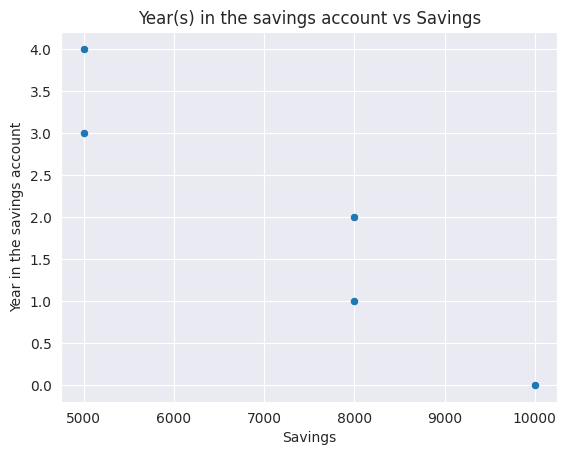

In [124]:
earning_data = {
    "savings": [5000, 5000, 8000, 8000, 10000],
    "when_to_save": [1, 2, 3, 4, 5] # after n year(s)
}

df_earning = pd.DataFrame(data=earning_data)


df_earning["year_in_savings_account"] = 5 - df_earning["when_to_save"]
print(df_earning)

ax = sns.scatterplot(data=df_earning, x = "savings", y="year_in_savings_account")

ax.set(
    title='Year(s) in the savings account vs Savings',
    xlabel='Savings',
    ylabel='Year in the savings account'
    )

plt.show()


In [130]:

r = 4/100
df_earning["future_value"] = df_earning.apply(lambda row: calculate_compounded_interest(row["savings"], 1, r, row["year_in_savings_account"]), axis=1)
print(df_earning)
print()
print("How much money will be in your account after 5 years?: ", get_formatted_amout(df_earning["future_value"].sum()))


   savings  when_to_save  year_in_savings_account  future_value
0     5000             1                        4     5849.2928
1     5000             2                        3     5624.3200
2     8000             3                        2     8652.8000
3     8000             4                        1     8320.0000
4    10000             5                        0    10000.0000

How much money will be in your account after 5 years?:  $38446.41
